In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()

import os
import sys

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

In [2]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/3),-1], h[int(nx/2),-1], Volume

L = 30.
T = 10.
nx = 300
nt = 12000
samples = 1000

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 100 == 0:
        print(f'Sample #{sample+1}', end='\r')
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

In [3]:
def FD_grad(M, pert = 0.0001, normalize = True):
    grad = np.zeros(M.shape)

    H, *_ = solution(nx, nt, L, T, M, basal_topology_func)
    
    for i in range(len(M)):
        
        if (i+1) % 100 == 0:
            print(f'Index #{i+1}', end='\r')
            
        M_pos = np.copy(M)
        M_pos[i] = M_pos[i]*(1+pert)
        H_pos, *_ = solution(nx, nt, L, T, M_pos, basal_topology_func)
        grad[i] = (H_pos - H) / (2*pert)

    grad = grad / np.max(np.abs(grad))
    
    return grad

grad_0 = FD_grad(M_samples[0])

In [4]:
Layers = [{'size': nx+1, 'activation': None    , 'use_bias': None},
          {'size': 10 , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1  , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(M_samples, H_samples, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 1000, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()

Train on 800 samples, validate on 200 samples
Epoch 1/1000


2023-08-01 05:41:59.064565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-2.1.3/installation/lib:/share/jdk-16.0.1/lib::
2023-08-01 05:41:59.064629: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-01 05:41:59.064671: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c5-3): /proc/driver/nvidia/version does not exist
2023-08-01 05:41:59.065509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural N

670/800 [========================>.....] - ETA: 0s - loss: 5.9574e-04 - mae: 0.0198
Epoch 1: val_loss improved from inf to 0.00053, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 417us/sample - loss: 5.7407e-04 - mae: 0.0196 - val_loss: 5.3152e-04 - val_mae: 0.0192
Epoch 2/1000
400/800 [==============>...............] - ETA: 0s - loss: 4.5542e-04 - mae: 0.0179
Epoch 2: val_loss improved from 0.00053 to 0.00051, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 172us/sample - loss: 4.6567e-04 - mae: 0.0184 - val_loss: 5.0682e-04 - val_mae: 0.0187
Epoch 3/1000
770/800 [===========================>..] - ETA: 0s - loss: 4.3784e-04 - mae: 0.0176
Epoch 3: val_loss improved from 0.00051 to 0.00049, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 187us/sample - loss: 4.3358e-04 - mae: 0.0175 - val_loss: 4.8715e-04 - val_mae: 0.0183
Epoch 4/1

770/800 [===========================>..] - ETA: 0s - loss: 4.9940e-05 - mae: 0.0056
Epoch 26: val_loss improved from 0.00012 to 0.00011, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 180us/sample - loss: 5.0171e-05 - mae: 0.0056 - val_loss: 1.0919e-04 - val_mae: 0.0082
Epoch 27/1000
790/800 [============================>.] - ETA: 0s - loss: 4.5392e-05 - mae: 0.0054
Epoch 27: val_loss did not improve from 0.00011
800/800 [==============================] - 0s 156us/sample - loss: 4.5650e-05 - mae: 0.0054 - val_loss: 1.3207e-04 - val_mae: 0.0088
Epoch 28/1000
390/800 [=============>................] - ETA: 0s - loss: 4.2266e-05 - mae: 0.0052
Epoch 28: val_loss improved from 0.00011 to 0.00010, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 173us/sample - loss: 4.2313e-05 - mae: 0.0051 - val_loss: 1.0007e-04 - val_mae: 0.0082
Epoch 29/1000
770/800 [===========================>..] - ET

740/800 [==========================>...] - ETA: 0s - loss: 2.8109e-05 - mae: 0.0042
Epoch 52: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 159us/sample - loss: 2.7665e-05 - mae: 0.0042 - val_loss: 4.9762e-05 - val_mae: 0.0059
Epoch 53/1000
800/800 [==============================] - ETA: 0s - loss: 2.1812e-05 - mae: 0.0038
Epoch 53: val_loss improved from 0.00005 to 0.00005, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 178us/sample - loss: 2.1812e-05 - mae: 0.0038 - val_loss: 4.5872e-05 - val_mae: 0.0057
Epoch 54/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.9930e-05 - mae: 0.0036
Epoch 54: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 161us/sample - loss: 2.0190e-05 - mae: 0.0036 - val_loss: 6.3020e-05 - val_mae: 0.0065
Epoch 55/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.4605e-05 - mae: 0.0040
Epoch 55: val_loss i

710/800 [=========================>....] - ETA: 0s - loss: 1.8375e-05 - mae: 0.0035
Epoch 80: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 1.8512e-05 - mae: 0.0035 - val_loss: 4.3714e-05 - val_mae: 0.0054
Epoch 81/1000
420/800 [==============>...............] - ETA: 0s - loss: 2.1135e-05 - mae: 0.0037
Epoch 81: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 2.0392e-05 - mae: 0.0036 - val_loss: 4.4357e-05 - val_mae: 0.0055
Epoch 82/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8602e-05 - mae: 0.0035
Epoch 82: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 169us/sample - loss: 1.8666e-05 - mae: 0.0035 - val_loss: 4.3300e-05 - val_mae: 0.0054
Epoch 83/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.7619e-05 - mae: 0.0034
Epoch 83: val_loss did not improve from 0.00004
800/800 [======================

770/800 [===========================>..] - ETA: 0s - loss: 2.3606e-05 - mae: 0.0039
Epoch 109: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 2.3660e-05 - mae: 0.0039 - val_loss: 5.4496e-05 - val_mae: 0.0060
Epoch 110/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.8244e-05 - mae: 0.0034
Epoch 110: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.8135e-05 - mae: 0.0034 - val_loss: 4.6812e-05 - val_mae: 0.0056
Epoch 111/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.9951e-05 - mae: 0.0036
Epoch 111: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.9484e-05 - mae: 0.0035 - val_loss: 4.9233e-05 - val_mae: 0.0057
Epoch 112/1000
790/800 [============================>.] - ETA: 0s - loss: 2.4398e-05 - mae: 0.0040
Epoch 112: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.9223e-05 - mae: 0.0035
Epoch 138: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 135us/sample - loss: 1.9482e-05 - mae: 0.0036 - val_loss: 4.7384e-05 - val_mae: 0.0056
Epoch 139/1000
460/800 [================>.............] - ETA: 0s - loss: 1.8081e-05 - mae: 0.0034
Epoch 139: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.7531e-05 - mae: 0.0033 - val_loss: 4.4576e-05 - val_mae: 0.0054
Epoch 140/1000
490/800 [=================>............] - ETA: 0s - loss: 1.5965e-05 - mae: 0.0032
Epoch 140: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 2.0270e-05 - mae: 0.0036 - val_loss: 4.3757e-05 - val_mae: 0.0054
Epoch 141/1000
460/800 [================>.............] - ETA: 0s - loss: 1.8025e-05 - mae: 0.0034
Epoch 141: val_loss did not improve from 0.00004
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.7090e-05 - mae: 0.0033
Epoch 167: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 126us/sample - loss: 1.9410e-05 - mae: 0.0035 - val_loss: 6.5978e-05 - val_mae: 0.0066
Epoch 168/1000
460/800 [================>.............] - ETA: 0s - loss: 1.8651e-05 - mae: 0.0034
Epoch 168: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.9778e-05 - mae: 0.0035 - val_loss: 5.4216e-05 - val_mae: 0.0060
Epoch 169/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.0280e-05 - mae: 0.0036
Epoch 169: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.9308e-05 - mae: 0.0035 - val_loss: 4.4248e-05 - val_mae: 0.0054
Epoch 170/1000
460/800 [================>.............] - ETA: 0s - loss: 1.8097e-05 - mae: 0.0034
Epoch 170: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 2.1795e-05 - mae: 0.0038
Epoch 196: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.9720e-05 - mae: 0.0036 - val_loss: 4.5424e-05 - val_mae: 0.0055
Epoch 197/1000
460/800 [================>.............] - ETA: 0s - loss: 1.5687e-05 - mae: 0.0032
Epoch 197: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.6732e-05 - mae: 0.0033 - val_loss: 4.5241e-05 - val_mae: 0.0055
Epoch 198/1000
470/800 [================>.............] - ETA: 0s - loss: 1.5940e-05 - mae: 0.0032
Epoch 198: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.6675e-05 - mae: 0.0033 - val_loss: 4.4742e-05 - val_mae: 0.0054
Epoch 199/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.0222e-05 - mae: 0.0035
Epoch 199: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 2.1231e-05 - mae: 0.0037
Epoch 225: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.8358e-05 - mae: 0.0034 - val_loss: 4.3973e-05 - val_mae: 0.0054
Epoch 226/1000
380/800 [=============>................] - ETA: 0s - loss: 1.6621e-05 - mae: 0.0032
Epoch 226: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.6942e-05 - mae: 0.0033 - val_loss: 4.4433e-05 - val_mae: 0.0054
Epoch 227/1000
450/800 [===============>..............] - ETA: 0s - loss: 2.0270e-05 - mae: 0.0036
Epoch 227: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.9960e-05 - mae: 0.0036 - val_loss: 4.4501e-05 - val_mae: 0.0054
Epoch 228/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.6507e-05 - mae: 0.0032
Epoch 228: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.4448e-05 - mae: 0.0030
Epoch 254: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.5371e-05 - mae: 0.0031 - val_loss: 4.8168e-05 - val_mae: 0.0056
Epoch 255/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8500e-05 - mae: 0.0035
Epoch 255: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.8960e-05 - mae: 0.0035 - val_loss: 4.5245e-05 - val_mae: 0.0054
Epoch 256/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.5245e-05 - mae: 0.0031
Epoch 256: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 1.5640e-05 - mae: 0.0031 - val_loss: 4.4775e-05 - val_mae: 0.0054
Epoch 257/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9093e-05 - mae: 0.0035
Epoch 257: val_loss did not improve from 0.00004
800/800 [===============

690/800 [========================>.....] - ETA: 0s - loss: 1.5859e-05 - mae: 0.0032
Epoch 283: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 176us/sample - loss: 1.5966e-05 - mae: 0.0032 - val_loss: 4.5648e-05 - val_mae: 0.0055
Epoch 284/1000
730/800 [==========================>...] - ETA: 0s - loss: 2.0124e-05 - mae: 0.0036
Epoch 284: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 168us/sample - loss: 1.9615e-05 - mae: 0.0035 - val_loss: 4.6495e-05 - val_mae: 0.0055
Epoch 285/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.6524e-05 - mae: 0.0032
Epoch 285: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.6506e-05 - mae: 0.0032 - val_loss: 5.0983e-05 - val_mae: 0.0057
Epoch 286/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.8437e-05 - mae: 0.0034
Epoch 286: val_loss did not improve from 0.00004
800/800 [===============

780/800 [============================>.] - ETA: 0s - loss: 1.6684e-05 - mae: 0.0033
Epoch 312: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.6670e-05 - mae: 0.0033 - val_loss: 4.5180e-05 - val_mae: 0.0054
Epoch 313/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.7777e-05 - mae: 0.0033
Epoch 313: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 165us/sample - loss: 1.8349e-05 - mae: 0.0034 - val_loss: 5.0343e-05 - val_mae: 0.0057
Epoch 314/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.6414e-05 - mae: 0.0032
Epoch 314: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 163us/sample - loss: 1.6201e-05 - mae: 0.0032 - val_loss: 4.6266e-05 - val_mae: 0.0055
Epoch 315/1000
790/800 [============================>.] - ETA: 0s - loss: 1.9218e-05 - mae: 0.0034
Epoch 315: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.7462e-05 - mae: 0.0033
Epoch 341: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.6182e-05 - mae: 0.0032 - val_loss: 4.6645e-05 - val_mae: 0.0055
Epoch 342/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6137e-05 - mae: 0.0032
Epoch 342: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.8837e-05 - mae: 0.0035 - val_loss: 5.7126e-05 - val_mae: 0.0062
Epoch 343/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8854e-05 - mae: 0.0034
Epoch 343: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.8015e-05 - mae: 0.0034 - val_loss: 4.8455e-05 - val_mae: 0.0056
Epoch 344/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7742e-05 - mae: 0.0033
Epoch 344: val_loss did not improve from 0.00004
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.9527e-05 - mae: 0.0035
Epoch 370: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.8375e-05 - mae: 0.0034 - val_loss: 4.5265e-05 - val_mae: 0.0054
Epoch 371/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.5422e-05 - mae: 0.0031
Epoch 371: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.6155e-05 - mae: 0.0031 - val_loss: 5.2540e-05 - val_mae: 0.0058
Epoch 372/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.6408e-05 - mae: 0.0032
Epoch 372: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 162us/sample - loss: 1.6517e-05 - mae: 0.0032 - val_loss: 4.7614e-05 - val_mae: 0.0055
Epoch 373/1000
800/800 [==============================] - ETA: 0s - loss: 1.7058e-05 - mae: 0.0033
Epoch 373: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.6193e-05 - mae: 0.0032
Epoch 399: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.7907e-05 - mae: 0.0034 - val_loss: 4.5289e-05 - val_mae: 0.0054
Epoch 400/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6240e-05 - mae: 0.0032
Epoch 400: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.7363e-05 - mae: 0.0033 - val_loss: 4.5182e-05 - val_mae: 0.0054
Epoch 401/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.8925e-05 - mae: 0.0035
Epoch 401: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.7110e-05 - mae: 0.0033 - val_loss: 4.5657e-05 - val_mae: 0.0054
Epoch 402/1000
780/800 [============================>.] - ETA: 0s - loss: 1.6383e-05 - mae: 0.0032
Epoch 402: val_loss did not improve from 0.00004
800/800 [===============

750/800 [===========================>..] - ETA: 0s - loss: 1.7261e-05 - mae: 0.0033
Epoch 428: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.7030e-05 - mae: 0.0033 - val_loss: 4.6854e-05 - val_mae: 0.0055
Epoch 429/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.5136e-05 - mae: 0.0031
Epoch 429: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.5131e-05 - mae: 0.0031 - val_loss: 4.6376e-05 - val_mae: 0.0055
Epoch 430/1000
430/800 [===============>..............] - ETA: 0s - loss: 2.3113e-05 - mae: 0.0038
Epoch 430: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 2.1312e-05 - mae: 0.0037 - val_loss: 5.8177e-05 - val_mae: 0.0061
Epoch 431/1000
460/800 [================>.............] - ETA: 0s - loss: 1.5134e-05 - mae: 0.0030
Epoch 431: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 1.4739e-05 - mae: 0.0030
Epoch 457: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.5841e-05 - mae: 0.0031 - val_loss: 4.5958e-05 - val_mae: 0.0054
Epoch 458/1000
780/800 [============================>.] - ETA: 0s - loss: 1.6416e-05 - mae: 0.0032
Epoch 458: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 1.6683e-05 - mae: 0.0032 - val_loss: 4.6381e-05 - val_mae: 0.0054
Epoch 459/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.7601e-05 - mae: 0.0034
Epoch 459: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 167us/sample - loss: 1.8194e-05 - mae: 0.0034 - val_loss: 4.7510e-05 - val_mae: 0.0056
Epoch 460/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.5017e-05 - mae: 0.0031
Epoch 460: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 1.4052e-05 - mae: 0.0030
Epoch 486: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.5676e-05 - mae: 0.0031 - val_loss: 4.8156e-05 - val_mae: 0.0055
Epoch 487/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.6190e-05 - mae: 0.0032
Epoch 487: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 174us/sample - loss: 1.6499e-05 - mae: 0.0032 - val_loss: 5.0323e-05 - val_mae: 0.0058
Epoch 488/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.6854e-05 - mae: 0.0032
Epoch 488: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 172us/sample - loss: 1.7302e-05 - mae: 0.0033 - val_loss: 5.7198e-05 - val_mae: 0.0062
Epoch 489/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.7937e-05 - mae: 0.0034
Epoch 489: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.4654e-05 - mae: 0.0031
Epoch 515: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 135us/sample - loss: 1.8006e-05 - mae: 0.0034 - val_loss: 5.0497e-05 - val_mae: 0.0056
Epoch 516/1000
780/800 [============================>.] - ETA: 0s - loss: 1.6208e-05 - mae: 0.0032
Epoch 516: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.6064e-05 - mae: 0.0031 - val_loss: 5.0604e-05 - val_mae: 0.0057
Epoch 517/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6980e-05 - mae: 0.0032
Epoch 517: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.7909e-05 - mae: 0.0033 - val_loss: 4.6218e-05 - val_mae: 0.0054
Epoch 518/1000
460/800 [================>.............] - ETA: 0s - loss: 1.3809e-05 - mae: 0.0029
Epoch 518: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.4307e-05 - mae: 0.0029
Epoch 544: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 135us/sample - loss: 1.5271e-05 - mae: 0.0031 - val_loss: 4.6093e-05 - val_mae: 0.0054
Epoch 545/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.1693e-05 - mae: 0.0037
Epoch 545: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 135us/sample - loss: 1.7764e-05 - mae: 0.0033 - val_loss: 4.6032e-05 - val_mae: 0.0054
Epoch 546/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6981e-05 - mae: 0.0033
Epoch 546: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.5948e-05 - mae: 0.0032 - val_loss: 5.1056e-05 - val_mae: 0.0056
Epoch 547/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6441e-05 - mae: 0.0032
Epoch 547: val_loss did not improve from 0.00004
800/800 [===============

750/800 [===========================>..] - ETA: 0s - loss: 1.5525e-05 - mae: 0.0031
Epoch 573: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.5315e-05 - mae: 0.0030 - val_loss: 4.6312e-05 - val_mae: 0.0054
Epoch 574/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.5319e-05 - mae: 0.0031
Epoch 574: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.5241e-05 - mae: 0.0031 - val_loss: 4.7311e-05 - val_mae: 0.0055
Epoch 575/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.4886e-05 - mae: 0.0031
Epoch 575: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.4811e-05 - mae: 0.0031 - val_loss: 4.7648e-05 - val_mae: 0.0055
Epoch 576/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.4690e-05 - mae: 0.0030
Epoch 576: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.6655e-05 - mae: 0.0032
Epoch 602: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.6340e-05 - mae: 0.0032 - val_loss: 5.6652e-05 - val_mae: 0.0059
Epoch 603/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.4848e-05 - mae: 0.0030
Epoch 603: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.4986e-05 - mae: 0.0030 - val_loss: 4.7230e-05 - val_mae: 0.0055
Epoch 604/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.4585e-05 - mae: 0.0030
Epoch 604: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.3852e-05 - mae: 0.0029 - val_loss: 4.7106e-05 - val_mae: 0.0055
Epoch 605/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.2235e-05 - mae: 0.0027
Epoch 605: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.3566e-05 - mae: 0.0029
Epoch 631: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.4555e-05 - mae: 0.0030 - val_loss: 4.6972e-05 - val_mae: 0.0055
Epoch 632/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.3333e-05 - mae: 0.0028
Epoch 632: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.5308e-05 - mae: 0.0031 - val_loss: 5.2945e-05 - val_mae: 0.0058
Epoch 633/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.5093e-05 - mae: 0.0031
Epoch 633: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 167us/sample - loss: 1.5476e-05 - mae: 0.0031 - val_loss: 5.4648e-05 - val_mae: 0.0058
Epoch 634/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.4553e-05 - mae: 0.0030
Epoch 634: val_loss did not improve from 0.00004
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.5989e-05 - mae: 0.0032
Epoch 660: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 152us/sample - loss: 1.5890e-05 - mae: 0.0031 - val_loss: 4.6955e-05 - val_mae: 0.0055
Epoch 661/1000
640/800 [=======================>......] - ETA: 0s - loss: 1.4026e-05 - mae: 0.0029
Epoch 661: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 185us/sample - loss: 1.4682e-05 - mae: 0.0030 - val_loss: 5.1731e-05 - val_mae: 0.0057
Epoch 662/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.6545e-05 - mae: 0.0032
Epoch 662: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 1.6581e-05 - mae: 0.0032 - val_loss: 4.9541e-05 - val_mae: 0.0056
Epoch 663/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.3525e-05 - mae: 0.0029
Epoch 663: val_loss did not improve from 0.00004
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 1.3806e-05 - mae: 0.0029
Epoch 689: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.4819e-05 - mae: 0.0030 - val_loss: 4.9084e-05 - val_mae: 0.0057
Epoch 690/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.5267e-05 - mae: 0.0031
Epoch 690: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.4771e-05 - mae: 0.0030 - val_loss: 4.7255e-05 - val_mae: 0.0055
Epoch 691/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.3405e-05 - mae: 0.0028
Epoch 691: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.5266e-05 - mae: 0.0030 - val_loss: 4.7514e-05 - val_mae: 0.0055
Epoch 692/1000
780/800 [============================>.] - ETA: 0s - loss: 1.4182e-05 - mae: 0.0029
Epoch 692: val_loss did not improve from 0.00004
800/800 [===============

730/800 [==========================>...] - ETA: 0s - loss: 1.5489e-05 - mae: 0.0031
Epoch 718: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 164us/sample - loss: 1.5549e-05 - mae: 0.0031 - val_loss: 4.7133e-05 - val_mae: 0.0055
Epoch 719/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.6383e-05 - mae: 0.0032
Epoch 719: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.6311e-05 - mae: 0.0032 - val_loss: 5.5023e-05 - val_mae: 0.0059
Epoch 720/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.4656e-05 - mae: 0.0030
Epoch 720: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.4630e-05 - mae: 0.0030 - val_loss: 4.8698e-05 - val_mae: 0.0057
Epoch 721/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.3189e-05 - mae: 0.0028
Epoch 721: val_loss did not improve from 0.00004
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 1.3464e-05 - mae: 0.0028
Epoch 747: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 146us/sample - loss: 1.4307e-05 - mae: 0.0029 - val_loss: 5.0352e-05 - val_mae: 0.0058
Epoch 748/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.5241e-05 - mae: 0.0031
Epoch 748: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.4587e-05 - mae: 0.0030 - val_loss: 4.9939e-05 - val_mae: 0.0056
Epoch 749/1000
790/800 [============================>.] - ETA: 0s - loss: 1.5228e-05 - mae: 0.0031
Epoch 749: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 155us/sample - loss: 1.5158e-05 - mae: 0.0031 - val_loss: 4.7690e-05 - val_mae: 0.0055
Epoch 750/1000
790/800 [============================>.] - ETA: 0s - loss: 1.4396e-05 - mae: 0.0030
Epoch 750: val_loss did not improve from 0.00004
800/800 [===============

440/800 [===============>..............] - ETA: 0s - loss: 1.3502e-05 - mae: 0.0029
Epoch 776: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 136us/sample - loss: 1.4389e-05 - mae: 0.0029 - val_loss: 4.7439e-05 - val_mae: 0.0055
Epoch 777/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.3308e-05 - mae: 0.0028
Epoch 777: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.6133e-05 - mae: 0.0031 - val_loss: 4.9187e-05 - val_mae: 0.0056
Epoch 778/1000
470/800 [================>.............] - ETA: 0s - loss: 1.5475e-05 - mae: 0.0031
Epoch 778: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 127us/sample - loss: 1.5429e-05 - mae: 0.0030 - val_loss: 5.8365e-05 - val_mae: 0.0060
Epoch 779/1000
460/800 [================>.............] - ETA: 0s - loss: 1.3679e-05 - mae: 0.0029
Epoch 779: val_loss did not improve from 0.00004
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.4671e-05 - mae: 0.0030
Epoch 805: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.4667e-05 - mae: 0.0030 - val_loss: 4.9364e-05 - val_mae: 0.0057
Epoch 806/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.3658e-05 - mae: 0.0029
Epoch 806: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.4265e-05 - mae: 0.0030 - val_loss: 4.8820e-05 - val_mae: 0.0056
Epoch 807/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.2830e-05 - mae: 0.0028
Epoch 807: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.3514e-05 - mae: 0.0029 - val_loss: 4.9289e-05 - val_mae: 0.0057
Epoch 808/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.4466e-05 - mae: 0.0030
Epoch 808: val_loss did not improve from 0.00004
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.2969e-05 - mae: 0.0028
Epoch 834: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.3264e-05 - mae: 0.0028 - val_loss: 4.8262e-05 - val_mae: 0.0056
Epoch 835/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.2247e-05 - mae: 0.0027
Epoch 835: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.3363e-05 - mae: 0.0028 - val_loss: 5.8077e-05 - val_mae: 0.0063
Epoch 836/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.4507e-05 - mae: 0.0029
Epoch 836: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.4059e-05 - mae: 0.0029 - val_loss: 5.0942e-05 - val_mae: 0.0057
Epoch 837/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.5708e-05 - mae: 0.0031
Epoch 837: val_loss did not improve from 0.00004
800/800 [===============

520/800 [==================>...........] - ETA: 0s - loss: 1.5089e-05 - mae: 0.0030
Epoch 863: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 119us/sample - loss: 1.5879e-05 - mae: 0.0031 - val_loss: 4.9830e-05 - val_mae: 0.0056
Epoch 864/1000
520/800 [==================>...........] - ETA: 0s - loss: 1.6645e-05 - mae: 0.0032
Epoch 864: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 118us/sample - loss: 1.6812e-05 - mae: 0.0033 - val_loss: 4.8778e-05 - val_mae: 0.0057
Epoch 865/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.2520e-05 - mae: 0.0027
Epoch 865: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 119us/sample - loss: 1.3297e-05 - mae: 0.0028 - val_loss: 5.7030e-05 - val_mae: 0.0062
Epoch 866/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.4297e-05 - mae: 0.0030
Epoch 866: val_loss did not improve from 0.00004
800/800 [===============

510/800 [==================>...........] - ETA: 0s - loss: 1.4451e-05 - mae: 0.0030
Epoch 892: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 122us/sample - loss: 1.3909e-05 - mae: 0.0029 - val_loss: 4.9125e-05 - val_mae: 0.0056
Epoch 893/1000
490/800 [=================>............] - ETA: 0s - loss: 1.3076e-05 - mae: 0.0029
Epoch 893: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 126us/sample - loss: 1.3412e-05 - mae: 0.0029 - val_loss: 4.8755e-05 - val_mae: 0.0056
Epoch 894/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.3513e-05 - mae: 0.0028
Epoch 894: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.3268e-05 - mae: 0.0028 - val_loss: 5.0102e-05 - val_mae: 0.0056
Epoch 895/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.2079e-05 - mae: 0.0027
Epoch 895: val_loss did not improve from 0.00004
800/800 [===============

490/800 [=================>............] - ETA: 0s - loss: 1.4147e-05 - mae: 0.0029
Epoch 921: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.4583e-05 - mae: 0.0030 - val_loss: 5.2190e-05 - val_mae: 0.0059
Epoch 922/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6988e-05 - mae: 0.0033
Epoch 922: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.6557e-05 - mae: 0.0032 - val_loss: 5.0882e-05 - val_mae: 0.0059
Epoch 923/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.4045e-05 - mae: 0.0029
Epoch 923: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.4361e-05 - mae: 0.0030 - val_loss: 5.6061e-05 - val_mae: 0.0059
Epoch 924/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.5147e-05 - mae: 0.0030
Epoch 924: val_loss did not improve from 0.00004
800/800 [===============

760/800 [===========================>..] - ETA: 0s - loss: 1.1946e-05 - mae: 0.0027
Epoch 950: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.2219e-05 - mae: 0.0027 - val_loss: 4.8839e-05 - val_mae: 0.0056
Epoch 951/1000
390/800 [=============>................] - ETA: 0s - loss: 1.2452e-05 - mae: 0.0027
Epoch 951: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 143us/sample - loss: 1.2850e-05 - mae: 0.0028 - val_loss: 4.8990e-05 - val_mae: 0.0056
Epoch 952/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.2395e-05 - mae: 0.0027
Epoch 952: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.3650e-05 - mae: 0.0028 - val_loss: 4.9961e-05 - val_mae: 0.0058
Epoch 953/1000
780/800 [============================>.] - ETA: 0s - loss: 1.3313e-05 - mae: 0.0028
Epoch 953: val_loss did not improve from 0.00004
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.3968e-05 - mae: 0.0030
Epoch 979: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.4196e-05 - mae: 0.0030 - val_loss: 5.2819e-05 - val_mae: 0.0057
Epoch 980/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.4451e-05 - mae: 0.0029
Epoch 980: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.3903e-05 - mae: 0.0028 - val_loss: 5.0237e-05 - val_mae: 0.0056
Epoch 981/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.3053e-05 - mae: 0.0028
Epoch 981: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.5050e-05 - mae: 0.0030 - val_loss: 5.3903e-05 - val_mae: 0.0058
Epoch 982/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.1860e-05 - mae: 0.0027
Epoch 982: val_loss did not improve from 0.00004
800/800 [===============

In [6]:
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.0}

X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'classic', M_samples[:2], normalizeDict, **kwargs)
a_a1b0, _  = X.quick_analyze()

X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:2], normalizeDict, **kwargs)
a_z, _  = X.quick_analyze()

L = TrainLR(M_samples, H_samples, y_ref = 0.0, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, _ = XL.quick_analyze()

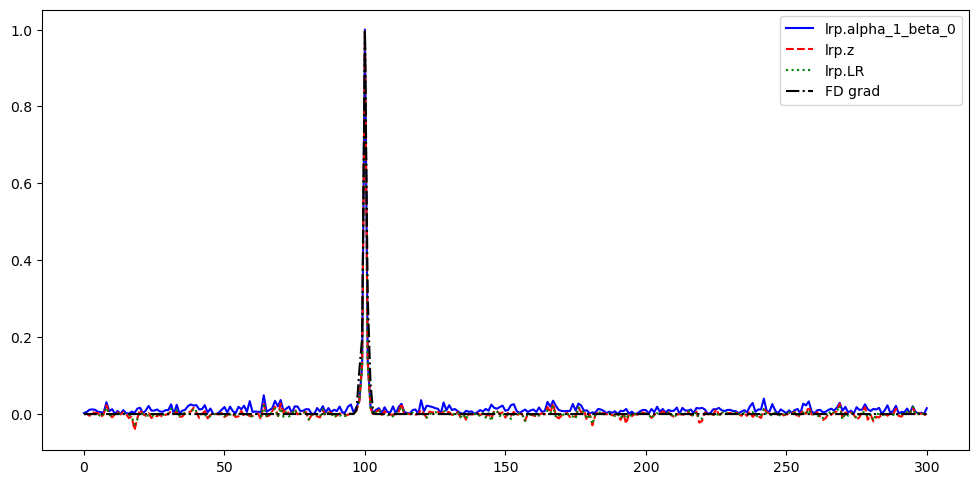

In [11]:
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots(1,1)
fig.tight_layout()

ax.plot(a_a1b0[0], 'b', label = 'lrp.alpha_1_beta_0')
ax.plot(a_z[0], 'r--', label = 'lrp.z')
ax.plot(a_LR[0], 'g:', label = 'lrp.LR')
ax.plot(grad_0, 'k-.', label = 'FD grad')
ax.legend()

In [ ]:
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.001}
X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'letzgus', M_samples[:2], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[1])

In [ ]:
%matplotlib inline
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [ ]:
y_ref = 0.001
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

In [ ]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [ ]:
L = TrainLR(M_samples, H_samples, y_ref = y_ref, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, stats_LR = XL.quick_analyze()

plt.plot(a_LR[0])
plt.plot(a_LR[1])

In [ ]:
y_ref = 0.0004
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

In [ ]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [ ]:
L = TrainLR(M_samples, H_samples, y_ref = y_ref, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, stats_LR = XL.quick_analyze()

plt.plot(a_LR[0])
plt.plot(a_LR[1])

In [ ]:
### Try one model with non-zero last layer bias

Layers = [{'size': nx+1, 'activation': None    , 'use_bias': None},
          {'size': 10 , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1  , 'activation': 'linear', 'use_bias': True}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(M_samples, H_samples, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 1000, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()

In [ ]:
y_ref = 0.0004
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

In [ ]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [ ]:
L = TrainLR(M_samples, H_samples, y_ref = y_ref, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, stats_LR = XL.quick_analyze()

plt.plot(a_LR[0])
plt.plot(a_LR[1])

In [ ]:
y_ref = 0.0
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'classic', M_samples, normalizeDict, **kwargs)
a_a1b0, _  = X.quick_analyze()
plt.plot(np.mean(a_a1b0, axis = 0))

In [ ]:
y_ref = 0.0
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples, normalizeDict, **kwargs)
a_z, _  = X.quick_analyze()
plt.plot(np.mean(a_z, axis = 0))